<a href="https://colab.research.google.com/github/EmmyGit/your-help/blob/main/Real_%26_fake_image_detection_2DCNN_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from glob import glob
from PIL import Image

In [ ]:
#Accesing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define path to the data directory
data_dir = Path('/content/drive/MyDrive/fake_ normal/')


In [ ]:
# Get the path to the real and fake sub-directories
fake_cases_dir = data_dir / 'training_fake'
real_cases_dir = data_dir / 'training_real'

# Get the list of all the images
fake_cases = fake_cases_dir.glob('*.png')
real_cases = real_cases_dir.glob('*.png')

In [ ]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []



    # Go through all the fake cases. The label for these cases will be 0
for img in fake_cases:
    train_data.append((img,1))


# Go through all the real_cases . The label for these cases will be 1
for img in real_cases:
    train_data.append((img, 0))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/MyDrive/fake_ normal/training_f...,1
1,/content/drive/MyDrive/fake_ normal/training_f...,1
2,/content/drive/MyDrive/fake_ normal/training_f...,1
3,/content/drive/MyDrive/fake_ normal/training_f...,1
4,/content/drive/MyDrive/fake_ normal/training_r...,0


In [ ]:
train_data['label'].unique()

array([1, 0])

In [ ]:
train_data.shape

(3240, 2)

1    1659
0    1581
Name: label, dtype: int64


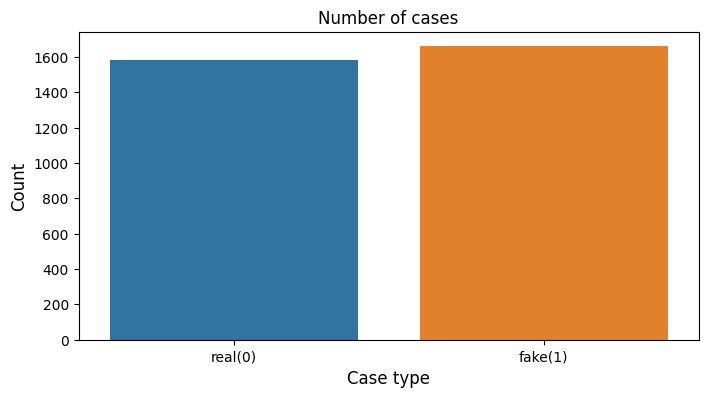

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results
plt.figure(figsize=(8,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=12)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['real(0)', 'fake(1)'])
plt.show()

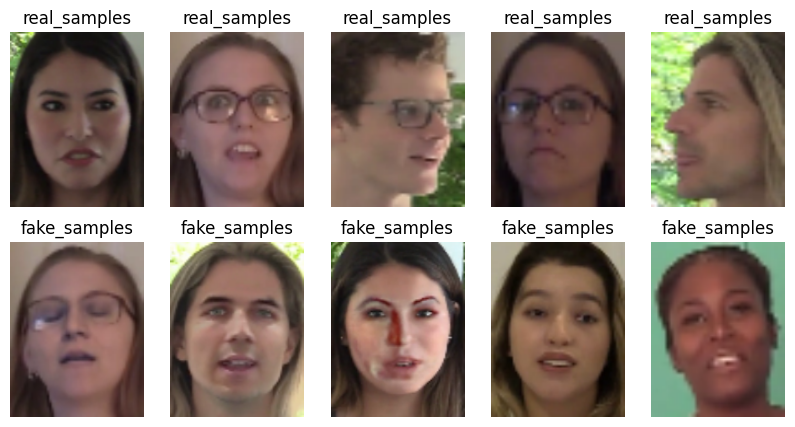

In [ ]:
# Get few samples for both the classes
real_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
fake_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()

# Concat the data in a single list
samples = real_samples+fake_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
  img = imread(samples[i])
  ax[i//5, i%5].imshow(img, cmap='gray')
  if i<5:
    ax[i//5, i%5].set_title("real_samples")
  else:
    ax[i//5, i%5].set_title("fake_samples")

  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
# Get the path to the real and fake sub-directories
real_cases_dir = data_dir / 'training_real'
fake_cases_dir = data_dir / 'training_fake'

# Get the list of all the images
real_cases = real_cases_dir.glob('*.png')
fake_cases = fake_cases_dir.glob('*.png')
train_data = []
train_labels = []

for img in real_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label ='real'
    train_data.append(img)
    train_labels.append(label)


for img in fake_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'fake'
    train_data.append(img)
    train_labels.append(label)
# Convert the list into numpy arrays

train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

Total number of validation examples:  (3240, 128, 128, 3)
Total number of labels: (3240,)


In [ ]:
train_data1.shape,

((3240, 128, 128, 3),)

In [ ]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,real
1,real
2,real
3,real
4,real


In [ ]:
train_labels1['label'].unique()

array(['real', 'fake'], dtype=object)

In [ ]:
train_labels1['label']=train_labels1['label'].map({'real':0,
                                                   'fake':1
                                                  })

In [ ]:
print(train_data1.shape)
print(train_labels1.shape)

(3240, 128, 128, 3)
(3240, 1)


In [ ]:
train_labels1.isnull().sum()

label    0
dtype: int64

In [ ]:
train_data1.shape, train_labels1.shape

((3240, 128, 128, 3), (3240, 1))

In [ ]:
train_data1 = np.array(train_data1)

In [ ]:
train_data1.shape, train_labels1.shape

((3240, 128, 128, 3), (3240, 1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data1, train_labels1, test_size=0.20, random_state=42)

In [ ]:
X_train = np.array(X_train)

In [ ]:
y_train = np.array(y_train)

In [ ]:
X_val = np.array(X_val)

In [ ]:
y_val = np.array(y_val)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                            patience=5,
                                            verbose=2,
                                            factor=0.1,
                                            min_lr=0.0001)
early_stops = EarlyStopping(monitor='loss',
                           min_delta=0,
                            patience=6,
                           verbose=2,
                           mode='auto')

checkpointer = ModelCheckpoint(filepath = 'cis3115.{epoch:02d}-{accuracy:.6f}.hdf5',
                               verbose=2,
                               save_best_only=True,
                               save_weights_only = True)


In [ ]:
from tensorflow.keras import regularizers
batchSize = 16
width = 128
height = 128
model = Sequential([
# installing tensorflow keras and importing libraries
    Conv2D(64, (3,3), activation = 'relu', input_shape=(width, height, 3), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3), activation ='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.2),
    Dense(16, activation = 'relu'),
    Dropout(0.2),
    Dense(8, activation = 'relu'),
    tf.keras.layers.Flatten(),
    Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5))
])

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),callbacks = [early_stops, learning_rate_reduction])

Epoch 1/40
81/81 [==============================] - 107s 1s/step - loss: 0.6889 - accuracy: 0.5571 - val_loss: 0.6062 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/40
81/81 [==============================] - 106s 1s/step - loss: 0.4863 - accuracy: 0.7720 - val_loss: 0.3430 - val_accuracy: 0.8858 - lr: 0.0010
Epoch 3/40
81/81 [==============================] - 106s 1s/step - loss: 0.2931 - accuracy: 0.8889 - val_loss: 0.1687 - val_accuracy: 0.9352 - lr: 0.0010
Epoch 4/40
81/81 [==============================] - 110s 1s/step - loss: 0.1958 - accuracy: 0.9356 - val_loss: 0.1491 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 5/40
81/81 [==============================] - 107s 1s/step - loss: 0.1472 - accuracy: 0.9525 - val_loss: 0.1024 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 6/40
81/81 [==============================] - 127s 2s/step - loss: 0.1272 - accuracy: 0.9587 - val_loss: 0.0733 - val_accuracy: 0.9784 - lr: 0.0010
Epoch 7/40
81/81 [==============================] - 107s 1s/step - loss: 0.0

KeyboardInterrupt: ignored

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("accuracy_plt.png")
plt.show()


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_plt.png")
plt.show()

 # Testing the a image with sample data

In [ ]:
#!mkdir -p saved_model
model.save('/content/drive/MyDrive/fake_ normal/fakeand real_model')

In [ ]:
# Get the path to the real and feak test data sub-directories
Tfake_cases_dir = data_dir / 'test_fake'
Treal_cases_dir = data_dir / 'test_real'

# Get the list of all the images
Tfake_cases = fake_cases_dir.glob('*.png')
Treal_cases = real_cases_dir.glob('*.png')

In [ ]:
# Get the path to the real and fake sub-directories

test_data = []
test_label = []

for img in Treal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label ='real'
    test_data.append(img)
    test_label.append(label)


for img in Tfake_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'fake'
    test_data.append(img)
    test_label.append(label)
# Convert the list into numpy arrays

test_data = np.array(test_data)
test_labels = np.array(test_label)

print("Total number of validation examples: ", test_data.shape)
print("Total number of labels:", test_label.shape)

In [ ]:
 #An empty list. We will insert the data into this list in (img_path, label) format
test_data = []



    # Go through all the fake cases. The label for these cases will be 0
for img in Tfake_cases:
    test_data.append((img,1))


# Go through all the real_cases . The label for these cases will be 1
for img in Treal_cases:
    test_data.append((img, 0))

# Get a pandas dataframe from the data we have in our list
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

In [ ]:

test_img = []
test_label = []
for img in Tfake_cases:
  img=np.array(img)
  img = img/255
  label = 'fake'
  test_img.append(img)
  test_label.append(label)


In [ ]:
test_img = []
test_label = []
for img in Treal_cases:
  img=np.array(img)
  img = img/255
  label = 'real'
  test_img.append(img)
  test_label.append(label)

In [ ]:
test_img = np.array(test_img)
test_labels = np.array(test_label)

In [ ]:
test_img = pd.DataFrame(test_img, columns=[ 'label'],index=None)
test_img.head()

In [ ]:
test_label['label'].unique()

In [ ]:
test_label['label']=test_label['label'].map({'real':0,
                                                   'fake':1
                                                  })

In [ ]:
test_label = pd.DataFrame(test_label, columns=[ 'label'],index=None)
test_label.head()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(test_img)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(test_label, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')